## Custom data loader:


In [1]:
from torch.utils.data import Dataset
from torchvision import transforms
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import torch
import cv2 as cv
import os


class FrameDataset(torch.utils.data.Dataset):
    def __init__(
        self, root, split, label_encoder, transform=None, target_transform=None
    ):
        # Assign attributes and paths
        self.root = os.path.join(root, split)
        self.transform = transform
        self.label_encoder = label_encoder
        self.target_transform = target_transform
        self.img_files = sorted(glob(os.path.join(self.root, "images/*/*/*.jpg")))
        self.columns = ["id", "class", "x1", "y1", "x2", "y2"]
        self.path_img = None

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        # Read img and annotation
        img_path = self.img_files[idx]
        annotations_path = (
            img_path.replace("images", "annotations")
            .replace(".jpg", ".txt")
            .replace("image", "annotations")
        )

        # Turn frame to tensor. Ready to return. Might need to change if we need temporal info
        frame = torch.tensor(cv.imread(img_path))

        # Reading annotations as a DataFrame due to strings. Maybe there is a more optimal way
        annos = pd.read_csv(
            annotations_path, names=self.columns, delimiter=" ", usecols=range(6)
        )

        # Turn DataFrame for boxes and labels into tensors
        target = {}
        target["boxes"] = torch.tensor(
            annos[["x1", "y1", "x2", "y2"]].astype(float).to_numpy(),
            dtype=torch.float32,
        )
        target["labels"] = torch.tensor(self.label_encoder.transform(annos["class"]))

        # Apply transform augmentation
        if self.transform:
            frame = self.transform(frame)
        if self.target_transform:
            target = self.target_transform(target)

        self.path_img = img_path
        return frame, target

    def getpath(self):
        # Return img path (only used for testing)
        return self.path_img

## Custom collate function:


In [2]:
from torch.nn.utils.rnn import pad_sequence


def custom_collate(batches):
    # batches is a list of samples, where each sample is a tuple (frame, target)
    frame, _ = zip(*batches)

    # Append each box/label tensor into their own variable
    boxes_list = [target["boxes"] for _, target in batches]
    labels_list = [target["labels"] for _, target in batches]
    # print(f"boxes list: {boxes_list}")
    # print(f"labels list: {labels_list}")

    # For each batch we pad the samples so they match the biggest tensor
    padded_boxes = pad_sequence(boxes_list)
    padded_labels = pad_sequence(labels_list)
    # print(f"padded_boxes: {padded_boxes}")
    # print(f"padded_labels: {padded_labels}")

    # Pack everything nicely as before
    packed_batch = [frame, {"boxes": padded_boxes, "labels": padded_labels}]
    # print(f"packed_batch: {packed_batch}")

    return packed_batch

In [3]:
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
from torchvision import transforms
import torch

# Create label encoder
label_encoder = LabelEncoder()
class_labels = ["human", "vehicle", "bicycle"]
# Unique Class Names:
# human
# bicycle
# vehicle
# motorcycle
label_encoder.fit(class_labels)

# Setup root directory dataset and dataloader
root_dir = "Split_Dataset"
"""
Assuming root_dir is structured as:
📁Split_Dataset
│
├─ 📁test
│   ├─ 📁images
│   ├─ 📁annotations
│
├─ 📁train
│   ├─ 📁images
│   ├─ 📁annotations
│
├─ 📁validation
    ├─ 📁images
    ├─ 📁annotations
"""

train_data = FrameDataset(root=root_dir, split="train", label_encoder=label_encoder)
dataloader = DataLoader(
    dataset=train_data, batch_size=1, shuffle=True, collate_fn=custom_collate
)  # Should work with any batch size

# Define the device (GPU if available, otherwise CPU)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Test prints
print(train_data.root)
print(train_data.transform)
print(train_data.label_encoder)
print(train_data.target_transform)
print(train_data.img_files)
print(train_data.columns)
print()
print(len(train_data.img_files))

Split_Dataset\train
None
LabelEncoder()
None
['Split_Dataset\\train\\images\\20200901\\clip_0_0000\\image_0000.jpg', 'Split_Dataset\\train\\images\\20200901\\clip_0_0000\\image_0001.jpg', 'Split_Dataset\\train\\images\\20200901\\clip_0_0000\\image_0002.jpg', 'Split_Dataset\\train\\images\\20200901\\clip_0_0000\\image_0003.jpg', 'Split_Dataset\\train\\images\\20200901\\clip_0_0000\\image_0004.jpg', 'Split_Dataset\\train\\images\\20200901\\clip_0_0000\\image_0005.jpg', 'Split_Dataset\\train\\images\\20200901\\clip_0_0000\\image_0006.jpg', 'Split_Dataset\\train\\images\\20200901\\clip_0_0000\\image_0007.jpg', 'Split_Dataset\\train\\images\\20200901\\clip_0_0000\\image_0008.jpg', 'Split_Dataset\\train\\images\\20200901\\clip_0_0000\\image_0009.jpg', 'Split_Dataset\\train\\images\\20200901\\clip_0_0000\\image_0010.jpg', 'Split_Dataset\\train\\images\\20200901\\clip_0_0000\\image_0011.jpg', 'Split_Dataset\\train\\images\\20200901\\clip_0_0000\\image_0012.jpg', 'Split_Dataset\\train\\images\\

labels: ['vehicle' 'human' 'human' 'human' 'human' 'human']


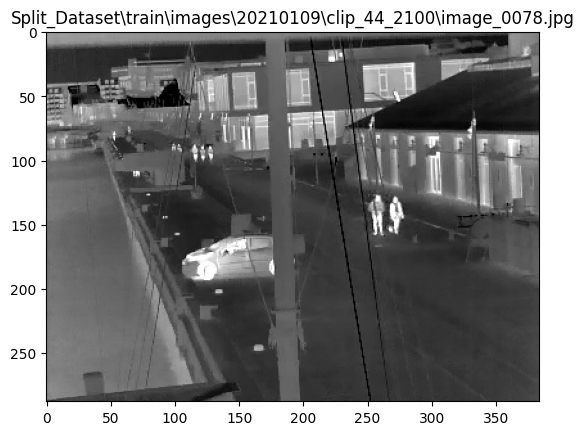

In [4]:
# Check first batch
batch = next(iter(dataloader))
frames, targets = batch
# print(f"targets: {targets}, type: {type(targets)}")
# print(f"targets['boxes']: {targets['boxes']}")
# print(f"targets['labels']: {targets['labels']}")
labels = label_encoder.inverse_transform(targets["labels"].ravel())
print(f"labels: {labels}")
img_path = train_data.getpath()
img = cv.imread(img_path)
plt.title(f"{img_path}")
plt.imshow(img)
plt.show()

## Find class names in annotations:


In [ ]:
import os
from concurrent.futures import ThreadPoolExecutor
import concurrent.futures
from tqdm import tqdm


def process_subfolder(root):
    classes = set()
    for root, dirs, files in os.walk(root):
        for file in files:
            file_path = os.path.join(root, file)
            if file.endswith(".txt"):
                try:
                    with open(file_path, "r") as file_anno:
                        for line in file_anno:
                            parts = line.strip().split()
                            if len(parts) >= 2:
                                class_name = parts[1]
                                classes.add(class_name)
                except Exception as e:
                    print(f"Error reading {file_path}: {str(e)}")
    return classes


def get_classes(dir):
    classes = set()
    subfolders = [root for root, dirs, files in os.walk(dir)]
    with tqdm(total=len(subfolders)) as pbar:
        with ThreadPoolExecutor(
            max_workers=400
        ) as executor:  # You can adjust the number of worker threads
            future_to_root = {
                executor.submit(process_subfolder, root): root for root in subfolders
            }
            for future in concurrent.futures.as_completed(future_to_root):
                root = future_to_root[future]
                result = future.result()
                classes.update(result)
                pbar.update(1)
    print("Finished finding classes")
    return classes


dir = "annotations"

class_names = get_classes(dir)

print("Unique Class Names:")
for class_name in class_names:
    print(class_name)

In [ ]:
# for batch in dataloader:
#    frames, targets = batch

#    test1 = label_encoder.inverse_transform(targets)

In [ ]:
# data_iter = iter(dataloader)
# test = next(data_iter)
# print()
# print(" PLACE HOLDER ")
# print()
# for i in range(len(test)):
#    print(f"Tensors {i}: {test[i][1]}")
#    print(f"Boxes {i}: {test[i][1]['boxes']}")
#    print(f"Labels {i}: {test[i][1]['labels']}")

# Original prints
# print(test[0][1])
# print("Boxes 1:", test[0][1]["boxes"])
# print("Labels 1:", test[0][1]["labels"])

# print(test[1][1])
# print("Boxes 2:", test[1][1]["boxes"])
# print("Labels 2:", test[1][1]["labels"])

# print(test.root)
# print(test.transform)
# print(test.label_encoder)
# print(test.target_transform)
# print(test.img_files)
# print(test.columns)
# print()
# print(len(test.img_files))
# print(test.img_files[1331])
# print(test[1331])

In [ ]:
# print(f"BATCH: {batch}")
# for i in range(len(batch)):
#     print(f"Tensors {i}: {batch[i][1]}")
#     print(f"Boxes {i}: {batch[i][1]['boxes']}")
#     print(f"Labels {i}: {batch[i][1]['labels']}")

# print(f"LEN: {len(batches)}")
# print(f"TYPE: {type(batches)}")
# len_boxes = []
# for i in range(len(batches)):
# print(f"print all {i}: {batch[i]}")
# print(f"boxes {i}: {batch[i][1]['boxes']}")
# boxes = batches[i][1]['boxes']
# len_boxes.append(len(boxes))
# print(f"len_box {i}: {len(boxes)}")

# print(f"Max objects: {max(len_boxes)}")

# for frame, target in batches:
#    num_boxes = target['boxes'].shape[0]
#    num_labels = target['labels'].shape[0]
# print(f"target boxes shape: {target['boxes'].shape}")
# print(f"target labels shape: {target['labels'].shape}")
# print(f"num_boxes: {num_boxes}")
# print(f"num_labels: {num_labels}")